In [1]:
import sqlite3 as sql

import numpy as np
import pandas as pd
from pandas import cut, read_sql
import pickle as pkl
from random import choices
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

In [2]:
indir_multiclass = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_pid_classification3_test/results.csv"
indir_track_cascade = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/dynedge_track_mu_Track_cascade_MP_data_SplitInIcePulses_on_equal_track_cascade_neutrinos_test/results.csv"
indir_energy = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/Peter_Morten_energy_1_mill_even_track_cascade_attempt_2_test_set/results.csv"
indir_zenith = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_zenith_1_mill_even_track_cascade_attempt2_test_set/results.csv"
indir_azimuth = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_MP_lvl3/trained_models/osc_next_level3_v2/MP_data_azimuth_test_1_mill_attempt2_test_set_equal_track_cascade/results.csv"



In [3]:
multiclass = pd.read_csv(indir_multiclass).sort_values('event_no').reset_index(drop = True)
track_cascade = pd.read_csv(indir_track_cascade).sort_values('event_no').reset_index(drop = True)
energy = pd.read_csv(indir_energy).sort_values('event_no').reset_index(drop = True)
zenith = pd.read_csv(indir_zenith).sort_values('event_no').reset_index(drop = True)
azimuth = pd.read_csv(indir_azimuth).sort_values('event_no').reset_index(drop = True)


In [4]:
print(np.shape(multiclass))
print(np.shape(track_cascade))
print(np.shape(energy))
print(np.shape(zenith))
print(np.shape(azimuth))

(22779358, 6)
(4585522, 4)
(4585522, 4)
(4585522, 6)
(4585522, 6)


In [5]:
pid_transform = {1:0,12:2,13:1,14:2,16:2}

predictions = []
truth = []

noise = 0
muons = 0
neutrinos = 0 

number = len(multiclass)

for i in range(number):# range(len(results)):
    noise_pred = multiclass['pid_noise_pred'].values[i]
    muon_pred = multiclass['pid_muon_pred'].values[i]
    neutrino_pred = multiclass['pid_neutrino_pred'].values[i]
    predictions.append(np.argmax([noise_pred,muon_pred,neutrino_pred]))

    truth.append(pid_transform[abs(multiclass['pid'].values[i])])
    #if pid_transform[abs(multiclass['pid'].values[i])] == 0:
    #    noise+=1
    #if pid_transform[abs(multiclass['pid'].values[i])] == 1:
    #    muons+=1
    #if pid_transform[abs(multiclass['pid'].values[i])] == 2:
    #    neutrinos+=1

print(f'there are {noise} noise, {muons} muons, and {neutrinos} neutrinos')

confusion_matrix = metrics.confusion_matrix(truth, predictions)

mask_noise = [True if truth[i] ==0 else False for i in range(len(truth))]
mask_muon = [True if truth[i] ==1 else False for i in range(len(truth))]
mask_neutrino = [True if truth[i] ==2 else False for i in range(len(truth))]


fpr_neutrino, tpr_neutrino , _ = metrics.roc_curve(truth,multiclass['pid_neutrino_pred'].values,pos_label=2)
fpr_muon, tpr_muon , _ = metrics.roc_curve(truth,multiclass['pid_muon_pred'].values,pos_label=1)
fpr_noise, tpr_noise , _ = metrics.roc_curve(truth,multiclass['pid_noise_pred'].values,pos_label=0)

auc_neutrino = metrics.auc(fpr_neutrino, tpr_neutrino)
auc_muon = metrics.auc(fpr_muon, tpr_muon)
auc_noise = metrics.auc(fpr_noise, tpr_noise)



there are 0 noise, 0 muons, and 0 neutrinos


/tmp/ipykernel_354/3181264898.py:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


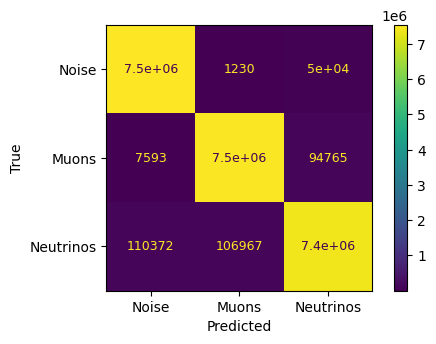

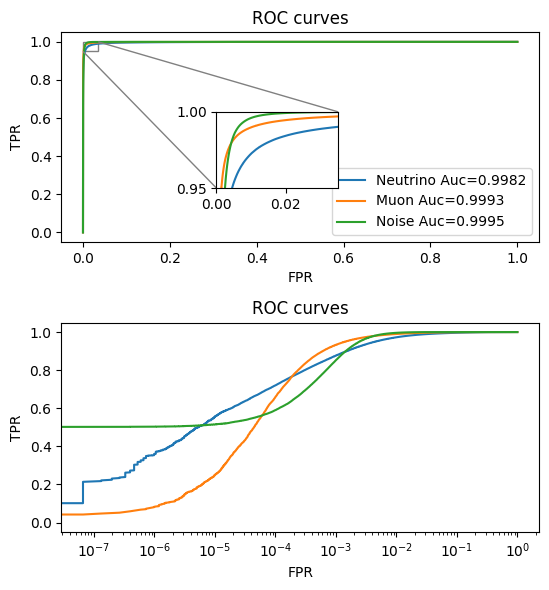

In [9]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from standard_plotting import set_size
fig, axs = plt.subplots(figsize=set_size('thesis'))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Noise','Muons','Neutrinos'])
cm_display.plot(ax=axs)

for labels in cm_display.text_.ravel():
    labels.set_fontsize(9)
axs.set_ylabel('True')
axs.set_xlabel('Predicted')


#fig.savefig(outdir+ 'Confusion_matrix_Multiclass_MC.pdf', format='pdf', bbox_inches='tight')


fig, axs = plt.subplots(2,1,figsize=set_size('thesis',subplots=(2, 1),y_size=6))

axs[0].plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axs[0].plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axs[0].plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')


axins = zoomed_inset_axes(axs[0], zoom=8, loc='lower right',bbox_to_anchor=(350,400)) # zoom = 6
axins.plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axins.plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axins.plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')

axins.set_xlim(0,0.035)
axins.set_ylim(0.95,1)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
mark_inset(axs[0], axins, loc1=1, loc2=3, fc="none", ec="0.5")
#plt.setp(axins, xticks=[], yticks=[])

axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
#axs[0].set_xscale('log')
axs[0].set_title('ROC curves')
axs[0].legend(loc='lower right')

axs[1].plot(fpr_neutrino, tpr_neutrino, label=f'Neutrino Auc={auc_neutrino:.4f}')
axs[1].plot(fpr_muon, tpr_muon, label=f'Muon Auc={auc_muon:.4f}')
axs[1].plot(fpr_noise, tpr_noise, label=f'Noise Auc={auc_noise:.4f}')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].set_xscale('log')
axs[1].set_title('ROC curves')
#axs[1].legend()

fig.tight_layout()
#fig.savefig(outdir+ 'ROC_Curves_Multiclass_MC.png', format='png', bbox_inches='tight')

#fig.savefig(outdir + 'Roc_curves.png')

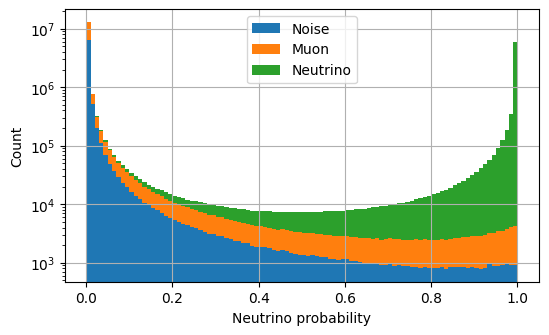

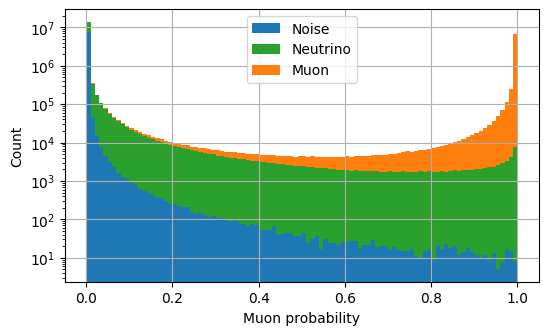

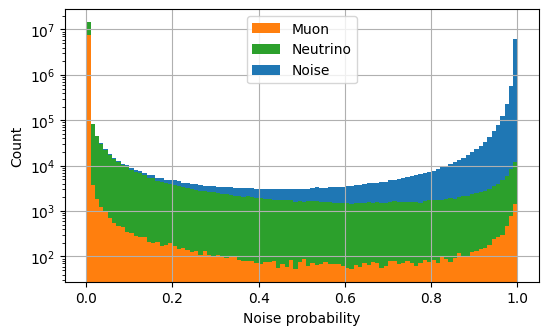

In [10]:
noise_mask = multiclass['pid'].isin([-1,1])
muon_mask = multiclass['pid'].isin([-13,13])
neutrino_mask = multiclass['pid'].isin([-12,12,-14,14,-16,16])

bins_to_use = np.linspace(0,1,101)
fig, axs = plt.subplots(figsize=set_size('thesis'))

plot_neutrino = [multiclass['pid_neutrino_pred'][noise_mask],multiclass['pid_neutrino_pred'][muon_mask],multiclass['pid_neutrino_pred'][neutrino_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='bar',stacked=True,label=['Noise','Muon','Neutrino'],color=['C0','C1','C2'])

#axs.set_title('Test set results')
axs.set_xlabel('Neutrino probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
axs.grid()
#axs.set_ylim(bottom=1)

fig.tight_layout()

fig, axs = plt.subplots(figsize=set_size('thesis'))
plot_neutrino = [multiclass['pid_muon_pred'][noise_mask],multiclass['pid_muon_pred'][neutrino_mask],multiclass['pid_muon_pred'][muon_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='bar',stacked=True,label=['Noise','Neutrino','Muon'],color=['C0','C2','C1'])

#axs.set_title('Test set results')
axs.set_xlabel('Muon probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
#axs.set_ylim(bottom=1)
axs.grid()
fig.tight_layout()



fig, axs = plt.subplots(figsize=set_size('thesis'))
plot_neutrino = [multiclass['pid_noise_pred'][muon_mask],multiclass['pid_noise_pred'][neutrino_mask],multiclass['pid_noise_pred'][noise_mask]]
axs.hist(plot_neutrino, bins_to_use, density=False, histtype='bar',stacked=True,label=['Muon','Neutrino','Noise'],color=['C1','C2','C0'])

#axs.set_title('Test set results')
axs.set_xlabel('Noise probability')
axs.set_ylabel('Count')
axs.set_yscale('log')
axs.legend()
axs.grid()
#axs.set_ylim(bottom=1)

fig.tight_layout()

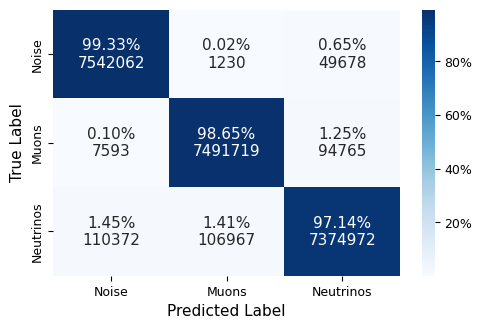

: 

In [11]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
    }   

    plt.rcParams.update(tex_fonts)
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    #sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d' % (p, c)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    #plt.savefig(filename,  bbox_inches='tight')

cm_analysis(truth, predictions,'confusion_matrix',[0,1,2],['Noise','Muons','Neutrinos'],figsize=set_size('thesis'))

In [32]:

fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(np.log10(energy['energy_pred']),bins=100,label='Predicted Energy',alpha=0.5)
hist = axs.hist(np.log10(energy['energy']),bins=100,label='True Energy',alpha=0.5)
axs.set_ylabel('count')
axs.set_xlabel('Energy log10 GeV')
axs.legend()
fig.tight_layout()



fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist2d(np.log10(energy['energy_pred']),np.log10(energy['energy']),bins=100)

axs.set_ylabel('True energy')
axs.set_xlabel('Predicted energy')

fig.colorbar(hist[3],ax=axs)
fig.tight_layout()

FileNotFoundError: missing font metrics file: cmr9

FileNotFoundError: missing font metrics file: cmr9

<Figure size 500x500 with 1 Axes>

with a kappa of  0 this percent of events are left: 1.0
with a kappa of  20 this percent of events are left: 0.18432012756671978


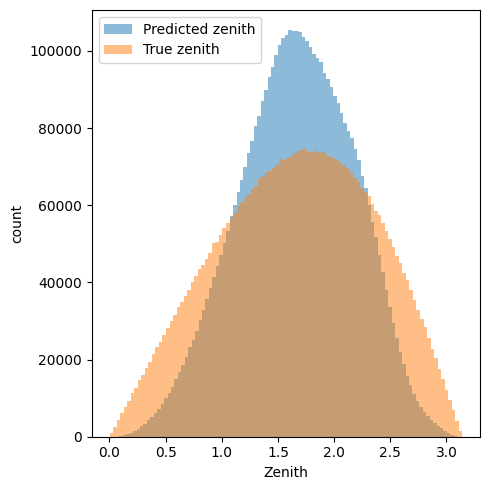

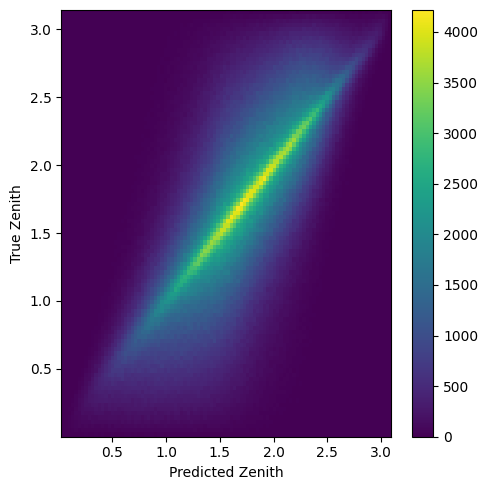

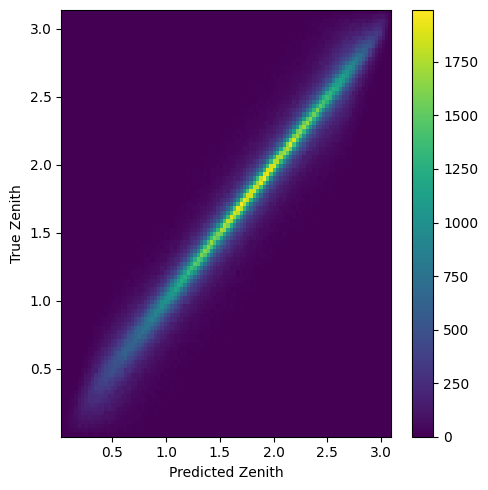

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(zenith['zenith_pred'],bins=100,label='Predicted zenith',alpha=0.5)
hist = axs.hist(zenith['zenith'],bins=100,label='True zenith',alpha=0.5)
axs.set_ylabel('count')
axs.set_xlabel('Zenith')
axs.legend()
fig.tight_layout()


fig, axs = plt.subplots(figsize=(5, 5))

kappa_cut = 0
print('with a kappa of ', str(kappa_cut) , 'this percent of events are left:',np.sum([zenith['zenith_kappa']>=kappa_cut])/len(zenith*100))
hist = axs.hist2d(zenith['zenith_pred'][zenith['zenith_kappa']>kappa_cut],zenith['zenith'][zenith['zenith_kappa']>kappa_cut],bins=100)

axs.set_ylabel('True Zenith')
axs.set_xlabel('Predicted Zenith')
fig.colorbar(hist[3],ax=axs)
fig.tight_layout()


fig, axs = plt.subplots(figsize=(5, 5))

kappa_cut = 20
print('with a kappa of ', str(kappa_cut) , 'this percent of events are left:',np.sum([zenith['zenith_kappa']>=kappa_cut])/len(zenith*100))
hist = axs.hist2d(zenith['zenith_pred'][zenith['zenith_kappa']>kappa_cut],zenith['zenith'][zenith['zenith_kappa']>kappa_cut],bins=100)

axs.set_ylabel('True Zenith')
axs.set_xlabel('Predicted Zenith')
fig.colorbar(hist[3],ax=axs)
fig.tight_layout()


#fig.savefig(outdir + 'Zenith_pred_2d_hist.png')

with a kappa of  0 this percent of events are left: 1.0
with a kappa of  2 this percent of events are left: 0.3520103054788528


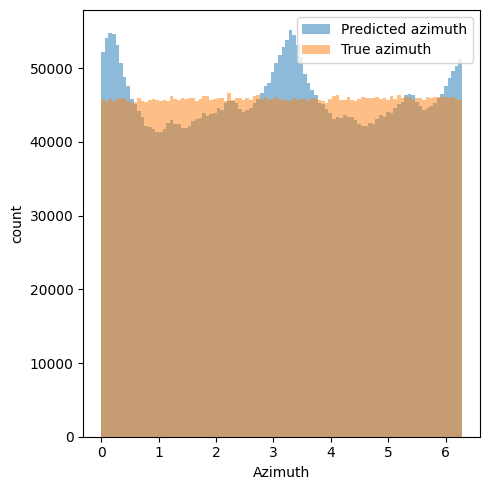

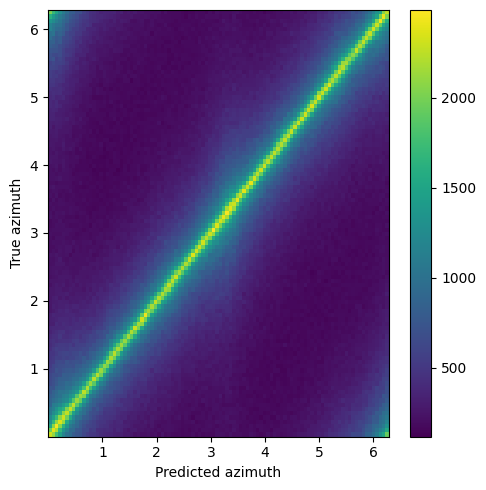

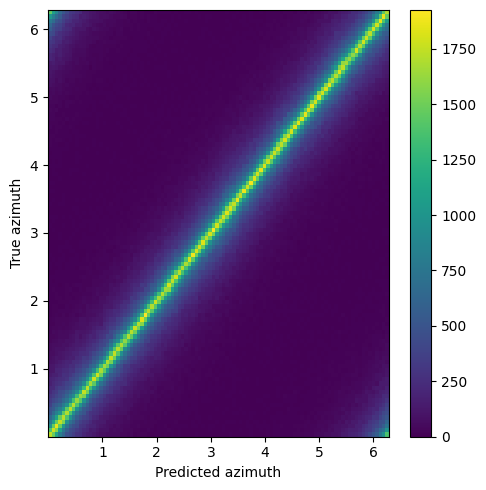

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(azimuth['azimuth_pred'],bins=100,label='Predicted azimuth',alpha=0.5)
hist = axs.hist(azimuth['azimuth'],bins=100,label='True azimuth',alpha=0.5)
axs.set_ylabel('count')
axs.set_xlabel('Azimuth')
axs.legend()
fig.tight_layout()


fig, axs = plt.subplots(figsize=(5, 5))

kappa_cut = 0
print('with a kappa of ', str(kappa_cut) , 'this percent of events are left:',np.sum([azimuth['azimuth_kappa']>=kappa_cut])/len(azimuth*100))
hist = axs.hist2d(azimuth['azimuth_pred'][azimuth['azimuth_kappa']>kappa_cut],azimuth['azimuth'][azimuth['azimuth_kappa']>kappa_cut],bins=100)

axs.set_ylabel('True azimuth')
axs.set_xlabel('Predicted azimuth')
fig.colorbar(hist[3],ax=axs)
fig.tight_layout()


fig, axs = plt.subplots(figsize=(5, 5))

kappa_cut = 2
print('with a kappa of ', str(kappa_cut) , 'this percent of events are left:',np.sum([azimuth['azimuth_kappa']>=kappa_cut])/len(azimuth*100))
hist = axs.hist2d(azimuth['azimuth_pred'][azimuth['azimuth_kappa']>kappa_cut],azimuth['azimuth'][azimuth['azimuth_kappa']>kappa_cut],bins=100)

axs.set_ylabel('True azimuth')
axs.set_xlabel('Predicted azimuth')
fig.colorbar(hist[3],ax=axs)
fig.tight_layout()





In [ ]:
track_cascade.head(5)

,Unnamed: 0,track_mu_pred,track_mu,event_no
0,4109962,0.511379,1.0,320.0
1,1810779,0.437622,1.0,344.0
2,3806952,0.412146,1.0,370.0
3,3266424,0.461440,1.0,378.0
4,1569369,0.516302,1.0,381.0


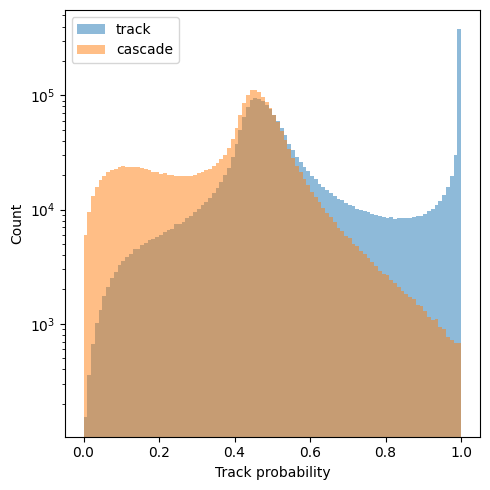

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(track_cascade['track_mu_pred'][track_cascade['track_mu'] == 1],bins=100,alpha=0.5,label='track')
hist = axs.hist(track_cascade['track_mu_pred'][track_cascade['track_mu'] == 0],bins=100,alpha=0.5,label='cascade')

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')
axs.legend()

fig.tight_layout()

In [ ]:
def logit(dataset,var):
    
    dataset['logit_'+var] = np.log(dataset[var]*0.9999+0.00001 - np.log(1-dataset[var]*0.9999+0.00001))

In [ ]:
logit(track_cascade,'track_mu_pred')

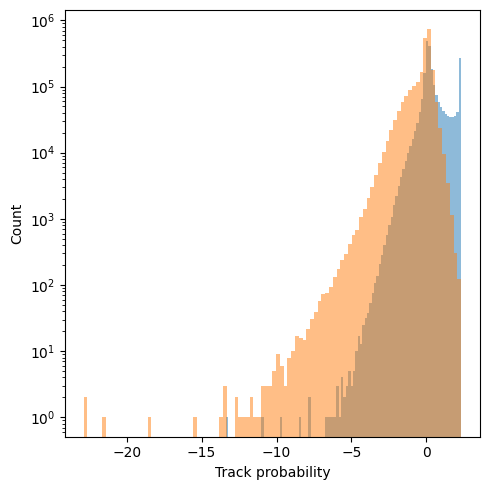

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(track_cascade['logit_track_mu_pred'][track_cascade['track_mu'] == 1],bins=100,alpha=0.5)
hist = axs.hist(track_cascade['logit_track_mu_pred'][track_cascade['track_mu'] == 0],bins=100,alpha=0.5)

axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Track probability')

fig.tight_layout()

In [ ]:
track_selection = track_cascade['event_no'][track_cascade['track_mu_pred'] > 0.9]
print(len(track_selection))

517440


In [ ]:
zenith_residual = zenith['zenith_pred'] - zenith['zenith']
azimuth_residual = azimuth['azimuth_pred'] - azimuth['azimuth']
azimuth_residual[azimuth_residual>np.pi] = azimuth_residual[azimuth_residual>np.pi] - np.pi
azimuth_residual[azimuth_residual<-np.pi] = azimuth_residual[azimuth_residual<-np.pi] + np.pi
energy_residual = np.log(energy['energy_pred']) - np.log(energy['energy'])

zenith['residual'] = zenith_residual
azimuth['residual'] = azimuth_residual
energy['residual'] = energy_residual


In [ ]:
print(max(zenith_residual))
print(min(zenith_residual))
print(max(azimuth_residual))
print(min(azimuth_residual))
print(max(energy_residual))
print(min(energy_residual))

2.4833260476589203
-2.5285900831222534
3.141589403152466
-3.141578197479248
5.227442241018833
-7.66066995993741


notice that these are scaled. There are only about  517440 of the tracks


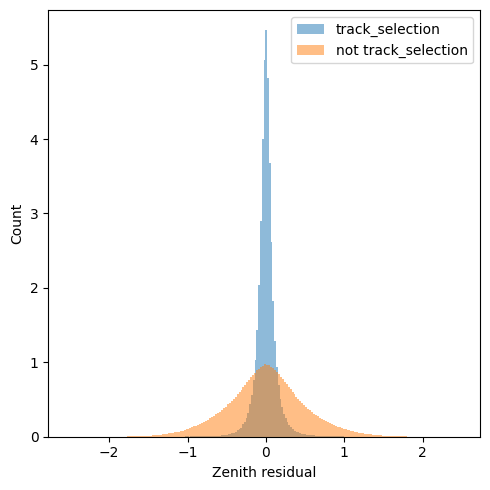

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(zenith_residual[zenith['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='track_selection')
hist = axs.hist(zenith_residual[~zenith['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='not track_selection')
print('notice that these are scaled. There are only about ',len(track_selection), 'of the tracks')
#axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('Zenith residual')
axs.legend()

fig.tight_layout()

notice that these are scaled. There are only about  517440 of the tracks


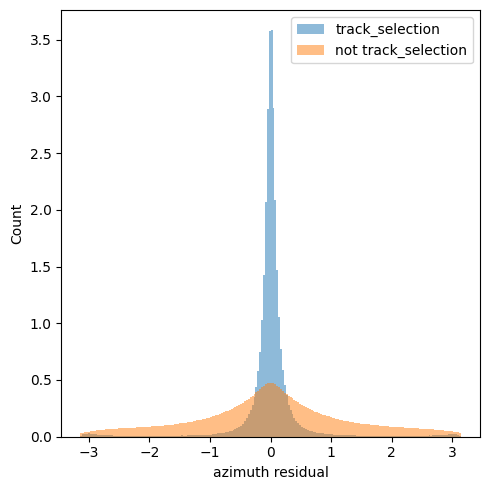

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(azimuth_residual[azimuth['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='track_selection')
hist = axs.hist(azimuth_residual[~azimuth['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='not track_selection')
print('notice that these are scaled. There are only about ',len(track_selection), 'of the tracks')
#axs.set_yscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('azimuth residual')
axs.legend()

fig.tight_layout()

notice that these are scaled. There are only about  517440 of the tracks


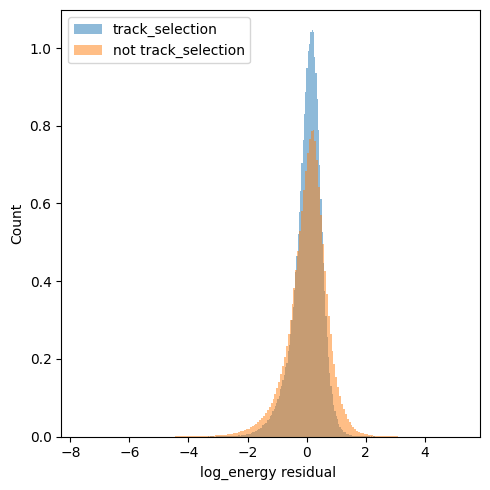

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(energy_residual[energy['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='track_selection')
hist = axs.hist(energy_residual[~energy['event_no'].isin(track_selection)],bins=200,alpha=0.5,density=True,label='not track_selection')
print('notice that these are scaled. There are only about ',len(track_selection), 'of the tracks')
#axs.set_xscale('log')
axs.set_ylabel('Count')
axs.set_xlabel('log_energy residual ')
#axs.set_xlim(-60,60)
axs.legend()

fig.tight_layout()

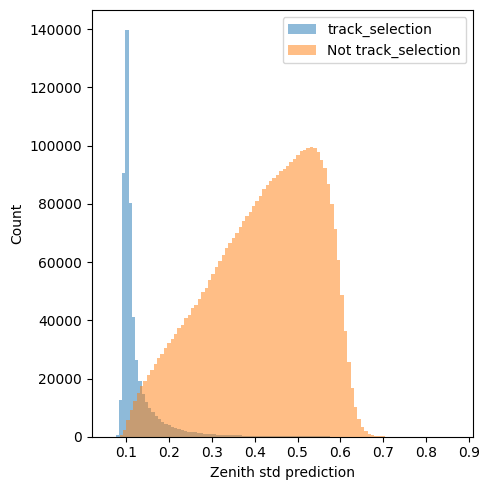

In [ ]:

fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(1/np.sqrt(zenith['zenith_kappa'][zenith['event_no'].isin(track_selection)]),bins=100,label='track_selection',alpha=0.5)
hist = axs.hist(1/np.sqrt(zenith['zenith_kappa'][~zenith['event_no'].isin(track_selection)]),bins=100,label='Not track_selection',alpha=0.5)

axs.set_ylabel('Count')
axs.set_xlabel('Zenith std prediction')
axs.legend()

fig.tight_layout()


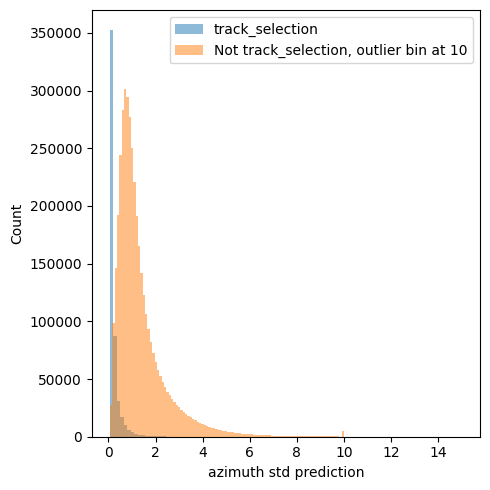

In [ ]:
fig, axs = plt.subplots(figsize=(5, 5))

hist = axs.hist(1/np.sqrt(azimuth['azimuth_kappa'][azimuth['event_no'].isin(track_selection)]),bins=100,label='track_selection',alpha=0.5)
hist = axs.hist(np.clip(1/np.sqrt(azimuth['azimuth_kappa'][~azimuth['event_no'].isin(track_selection)]),0,10),bins=100,label='Not track_selection, outlier bin at 10',alpha=0.5)

axs.set_ylabel('Count')
axs.set_xlabel('azimuth std prediction')
axs.legend()

fig.tight_layout()

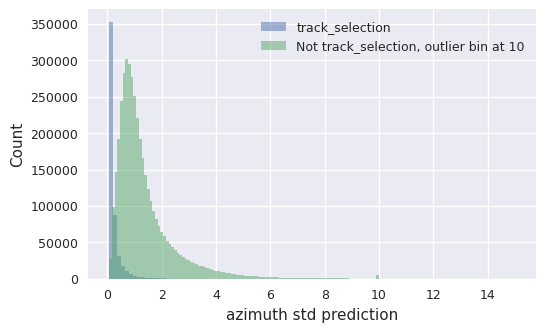

In [47]:

from standard_plotting import set_size
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9
}

plt.rcParams.update(tex_fonts)

fig, axs = plt.subplots(figsize=set_size('thesis'))

hist = axs.hist(1/np.sqrt(azimuth['azimuth_kappa'][azimuth['event_no'].isin(track_selection)]),bins=100,label='track_selection',alpha=0.5,color='C0')
hist = axs.hist(np.clip(1/np.sqrt(azimuth['azimuth_kappa'][~azimuth['event_no'].isin(track_selection)]),0,10),bins=100,label='Not track_selection, outlier bin at 10',alpha=0.5,color='C1')

axs.set_ylabel('Count')
axs.set_xlabel('azimuth std prediction')
#axs.set_yscale('log')
axs.legend()

fig.tight_layout()

fig.savefig('example_1.png', format='png', bbox_inches='tight')

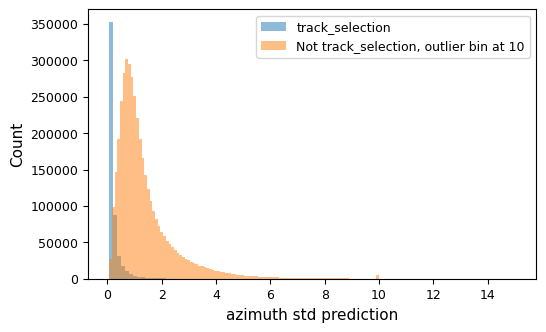